In [1]:
# Based on https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/03_problem_representation/rebalancing.ipynb.
#   !gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

import xgboost as xgb
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [1]:
# TODO
#  conufion matrix
#  refactoring

SEED = 42
NROWS = None #100000 

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
    df = pd.get_dummies(df)
    return df

def fraud_rate_df(df: pd.DataFrame) -> float:
    fraud_df = df[df['isFraud'] == 1]
    return len(fraud_df)/len(df)

def fraud_rate(y) -> float:
    fraud_indices = np.where(y == 1)[0]
    return len(fraud_indices) / len(y) # type: ignore

def train_split(df: pd.DataFrame):
    y = df.isFraud.values
    X_train, X_test, _, y_test = train_test_split(df, y, stratify=y, test_size=0.2, random_state=SEED)
    train_df = pd.DataFrame(data=X_train, columns=df.columns)
    X_test.drop(columns=['isFraud'], inplace=True) # type: ignore
    return train_df, X_test, y_test

# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")                 
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_and_eval(df: pd.DataFrame, should_down_sample: bool=False, frac: float=1.0):

    train_df, X_test, y_test = train_split(df)

    # down_sample
    if should_down_sample:
        print(f"Down sample train {frac}")
        fraud = train_df[train_df['isFraud'] == 1]
        not_fraud = train_df[train_df['isFraud'] == 0]
        not_fraud_sample = not_fraud.sample(random_state=SEED, frac=frac)
        train_df = pd.concat([not_fraud_sample,fraud])
        train_df = shuffle(train_df, random_state=SEED)    
    else:
        print("Original train")

    X_train = train_df.drop(columns=['isFraud']).values
    y_train = train_df.isFraud.values

    print(f'Fraud Rate in (all, train, test)=({fraud_rate_df(df):.5f}, {fraud_rate(y_train):.5f}, {fraud_rate(y_test):.5f})')

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(y_pred)

    print(f'f1_score: {f1_score(y_test, y_pred):.2f}')
    cm = confusion_matrix(y_test, y_pred)
    classes = ['not fraud', 'fraud']    
    plot_confusion_matrix(cm, classes, normalize=True)    

NameError: name 'pd' is not defined

In [2]:
df = pd.read_csv('/kaggle/input/fraud_data_kaggle.csv', nrows=NROWS)
df = process_data(df)
df.head()

NameError: name 'pd' is not defined

In [3]:
train_and_eval(df)

NameError: name 'train_and_eval' is not defined

In [4]:
train_and_eval(df, should_down_sample=True, frac=0.0001)

NameError: name 'train_and_eval' is not defined

Down sample train 0.005
Fraud Rate in (all, train, test)=(0.00129, 0.20539, 0.00129)
[0 0 0 ... 0 0 0]
f1_score: 0.40


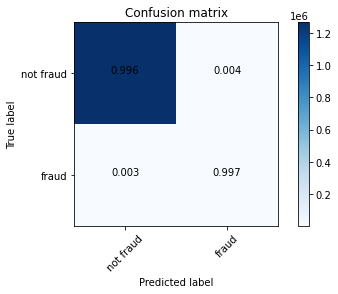

In [6]:
train_and_eval(df, should_down_sample=True, frac=0.005)

Down sample train 0.001
Fraud Rate in (all, train, test)=(0.00129, 0.56375, 0.00129)
[0 0 0 ... 0 0 0]
f1_score: 0.19


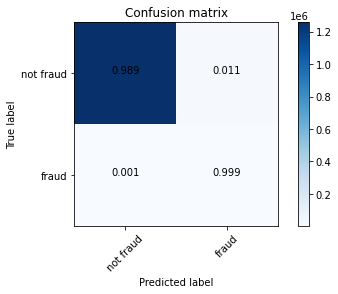

In [7]:
train_and_eval(df, should_down_sample=True, frac=0.001)